In [17]:
%matplotlib notebook
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torch.distributions import Dirichlet

In [30]:
d = 32
T = 2048  # number of frames
lr = 0.01  # learning rate
gamma = 0.9999  # scheduler parameter

In [31]:
p = Dirichlet(torch.rand(d))
# estimate 1
theta = torch.rand(d).requires_grad_(True)
optimizer = torch.optim.Adam([theta,], lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
reinf_loss = torch.empty(T)

avg = 0.
alpha = 0.95

for t in range(T):
    q = Dirichlet(theta.exp())
    pi = q.sample()
    loss = (q.log_prob(pi) - p.log_prob(pi) - avg).detach() * q.log_prob(pi)
    loss.backward()
    reinf_loss[t] = torch.distributions.kl.kl_divergence(q, p).detach()
    
    avg = (1 - alpha) * reinf_loss[t] + alpha * avg
    
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

In [32]:
# estimate 2
theta = torch.rand(d).requires_grad_(True)
optimizer = torch.optim.Adam([theta,], lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
reparam_loss = torch.empty(T)
    
for t in range(T):
    q = Dirichlet(theta.exp())
    pi = q.rsample()
    loss = (q.log_prob(pi) - p.log_prob(pi))
    loss.backward()
    reparam_loss[t] = torch.distributions.kl.kl_divergence(q, p).detach()
    
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

<IPython.core.display.Javascript object>


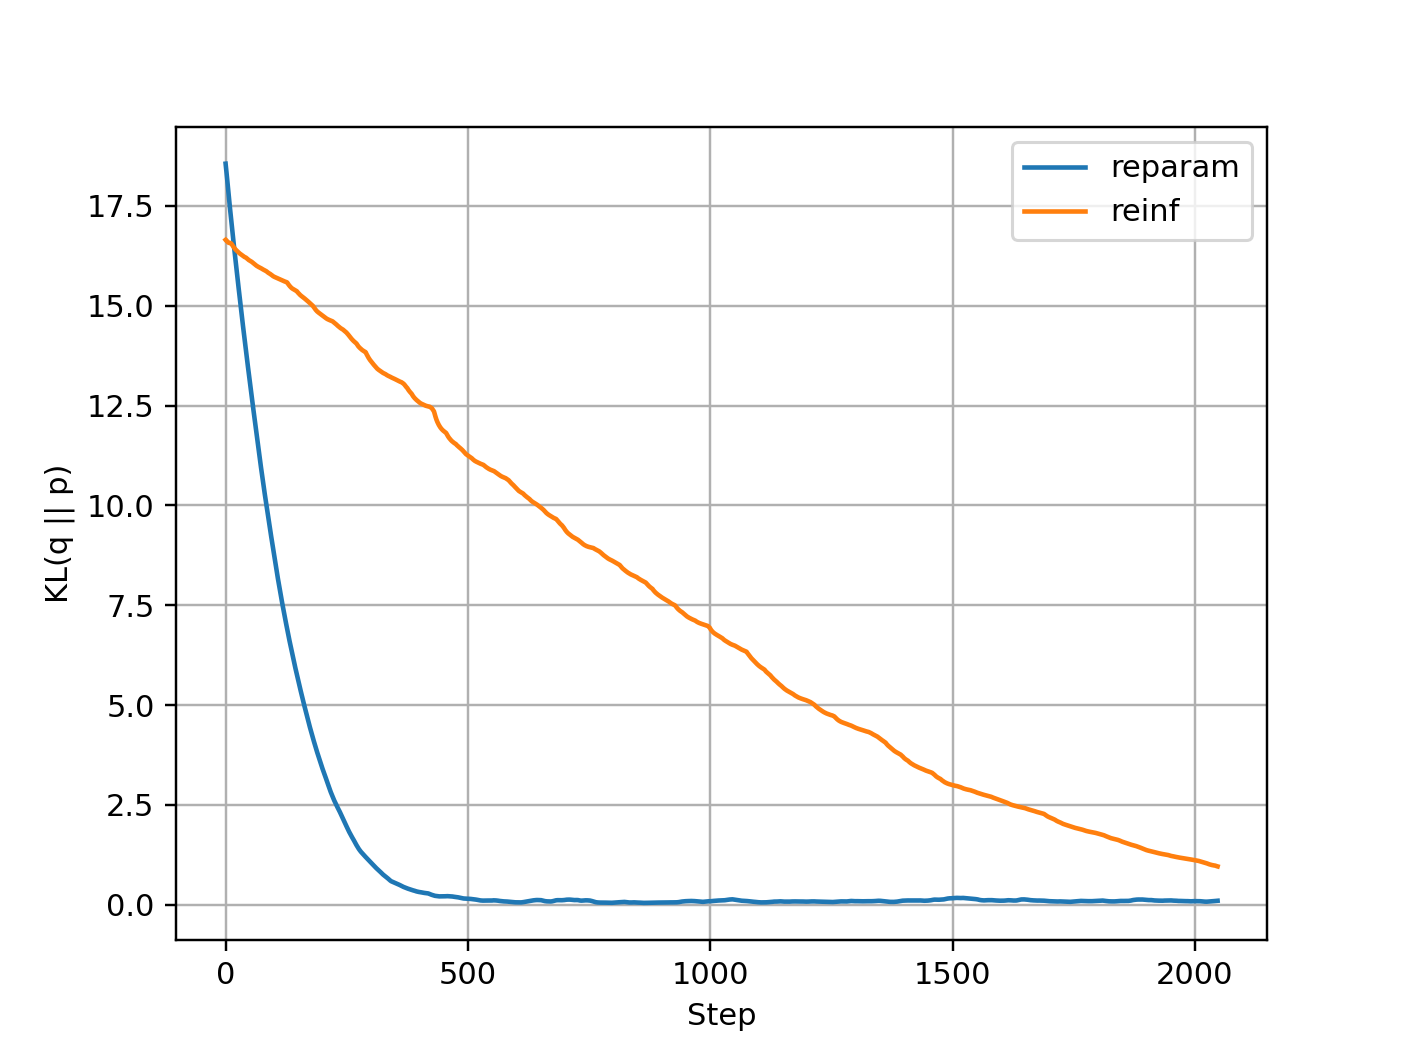

In [33]:
plt.plot(reparam_loss, label='reparam')
plt.plot(reinf_loss, label='reinf')
plt.xlabel('Step')
plt.ylabel('KL(q || p)')
plt.grid()
plt.legend();